# Data Load

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# 각 파일 로드
admissions = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/hosp/admissions.csv', dtype={'deathtime': 'object','icd_code': 'object', 'hadm_id': 'float64'})
patients = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/hosp/patients.csv', dtype={'icd_code': 'object'})
microbiologyevents = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/hosp/microbiologyevents.csv',
                                dtype={
                                    'ab_name': 'object',
                                    'dilution_comparison': 'object',
                                    'dilution_text': 'object',
                                    'interpretation': 'object',
                                    'org_name': 'object',
                                    'quantity': 'object',
                                    'icd_code': 'object'
                                })

diagnoses_icd = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/hosp/diagnoses_icd.csv', dtype={'icd_code': 'object', 'hadm_id': 'float64'})
d_icd_procedures = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/hosp/d_icd_procedures.csv',dtype={'icd_code': 'object'})
drgcodes = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/hosp/drgcodes.csv', dtype={'hadm_id': 'float64'})
hcpcsevents = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/hosp/hcpcsevents.csv', dtype={'hadm_id': 'float64'})
omr = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/hosp/omr.csv')
services = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/hosp/services.csv', dtype={'hadm_id': 'float64', 'prev_service': 'object'})
transfers = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/hosp/transfers.csv', dtype={'hadm_id': 'float64'})
caregiver = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/icu/caregiver.csv')
procedureevents = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/icu/procedureevents.csv', dtype={'hadm_id': 'float64', 'originalamount': 'float64'})
d_items = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/icu/d_items.csv')
datetimeevents = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/icu/datetimeevents.csv', dtype={'hadm_id': 'float64'})
icustays = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/icu/icustays.csv', dtype={'hadm_id': 'float64'})
inputevents = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/icu/inputevents.csv', dtype={'hadm_id': 'float64', 'originalamount': 'float64', 'originalrate': 'float64', 'totalamount': 'float64'})
outputevents = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/icu/outputevents.csv', dtype={'hadm_id': 'float64', 'value': 'float64'})
chartevents = pd.read_csv('/content/drive/MyDrive/MIMIC-IV_V2.2/icu/chartevents.csv', dtype={
    'hadm_id': 'float64',
    'caregiver_id': 'float64',
    'value': 'object',
    'valuenum': 'float64',
    'warning': 'float64'
})


# Feature Extraction & Feature Engineering

**해당 과정에서의 목적:**

> 우리는 주어진 환자의 간단한 검사 기록을 기반으로 과거 데이터를 활용하여 주어진 환자의 사망 가능성을 예측하고자 한다.



1.   z_score_absolute: 주어진 환자의 모든 검사 기록에 대한 z_score의 평균의 절댓값. 높을수록 환자의 검사 기록이 일반적인 상황에서 벗어난다고 생각할 수 있음.
2. drg_severity / mortality: 주어진 환자의 모든 검사 기록에 대한 의사가 판단한 severity 및 mortality의 평균 값. 이 값이 높을수록 severity/mortality가 높다고 생각할 수 있음.
3. avg_drg_severity / avg_drg_mortality: 각 drg_code별 평균 severity/mortality를 계산하여 주어진 환자의 모든 검사 기록에 대한 그것의 평균값을 환산함. 의사의 환자별 mortality 및 severity 판단의 bias를 제거하고, 해당 drg_code의 평균적으로 판단된 severity 및 mortality를 반영하기 위함임.





In [3]:
#drgcodes, patients, admissions 데이터를 subject_id를 기준으로 merge
data = drgcodes.merge(admissions, on = ['subject_id', 'hadm_id']).merge(patients, on = ['subject_id']).iloc[:, [0, 1, 2, 5, 6, 14, 15, 16, 17, 21, 22, 23, 25]]

In [4]:
#각 진료검사 항목에 대해 평균과 표준편차를 계산함
item_stats = pd.DataFrame([chartevents.groupby('itemid')['valuenum'].std(),chartevents.groupby('itemid')['valuenum'].mean()]).T
item_stats.columns = ['std', 'mean']
item_stats = item_stats.reset_index()

In [5]:
#chartevent의 진료 항목에 대해 각 subject_id별 각 진료검사 항목 별 평균을 계산함
subject_stats = pd.DataFrame(chartevents.groupby(['subject_id', 'itemid'])['valuenum'].mean()).reset_index()

In [6]:
#결측치는 제거함
subject_stats = subject_stats.dropna()
item_stats = item_stats.dropna()

In [7]:
#item_stats와 subject_stats를 merge하여 각 subject_id별 각 진료검사 항목 별 평균과 그 항목의 평균 및 표준편차를 가져올 수 있도록 함
subject_item_stats = subject_stats.merge(item_stats, on = 'itemid')

In [8]:
# z_score 절댓값 변수 생성하여 얼마나 해당 환자에 대해 각 진료검사별로 일반적이지 않은 결과가 나왔는지 계산할 수 있도록 함
subject_item_stats['z_score_absolute'] = (abs((subject_item_stats['valuenum'] - subject_item_stats['mean'])/subject_item_stats['std']))

In [9]:
#각 환자별로 진료검사에 대해 z_score 절댓값 변수의 평균을 구해 DataFrame으로 생성
subject_z_scores = pd.DataFrame(subject_item_stats.groupby('subject_id')['z_score_absolute'].mean()).reset_index()

In [10]:
#기존 데이터에 merge
data =data.merge(subject_z_scores, on = 'subject_id')

In [12]:
#dod (사망일) 변수에서 해당 환자의 사망 여부 변수를 생성하여 data에 추가
data['dod'] = pd.to_datetime(data['dod'])
data['year'] = data['dod'].dt.year
data['difference_year'] = data['year'] - data['anchor_year']
data['is_dead'] = (~data['difference_year'].isna()).astype(int)
data = data.drop('difference_year', axis = 1)

In [13]:
#필요없는 컬럼은 제거
data = data.drop(['dod', 'year', 'anchor_year'], axis = 1)

In [14]:
#각 환자가 받은 severity와 mortality의 평균값을 구해 drg_info DataFrame으로 만들기
drg_info = pd.DataFrame([data.groupby('subject_id')['drg_severity'].mean(),data.groupby('subject_id')['drg_mortality'].mean()]).T.reset_index()

In [15]:
#환자별로 데이터를 낼 수 있도록 환자별로 달랐던 데이터를 제거한 뒤 drop_duplicates 사용
data_to_merge = data.drop(['drg_type', 'drg_severity', 'drg_mortality', 'hadm_id', 'insurance'], axis = 1).drop_duplicates()

In [16]:
#drg_info와도 병합
data_to_train = data_to_merge.merge(drg_info, on = 'subject_id').dropna()

In [35]:
#drg_code_info에 drg_code별 평균 severity 및 mortality 계산
drg_code_info = pd.DataFrame([drgcodes.groupby('drg_code')['drg_severity'].mean(), drgcodes.groupby('drg_code')['drg_mortality'].mean()]).T.reset_index()
drg_code_info.columns = ['drg_code', 'avg_drg_severity', 'avg_drg_mortality']

In [37]:
#drgcodes data에 병합
drgcodes_to_merge = drgcodes.merge(drg_code_info, on = 'drg_code')

In [48]:
#각 환자 별 avg_drg_severity 및 avg_drg_mortality의 평균을 구해 drg_avg_info에 입력
drg_avg_info = pd.DataFrame([drgcodes_to_merge.groupby('subject_id')['avg_drg_severity'].mean(),drgcodes_to_merge.groupby('subject_id')['avg_drg_mortality'].mean()]).T.reset_index()

In [53]:
#기존 데이터에 merge
data_to_train = data_to_train.merge(drg_avg_info, on = 'subject_id').dropna()

In [18]:
#인종 변수를 단순화함
def simplify_race(race):
    white = ['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN']
    black = ['BLACK/AFRICAN AMERICAN', 'BLACK/AFRICAN', 'BLACK/CAPE VERDEAN', 'BLACK/CARIBBEAN ISLAND']
    asian = ['ASIAN - SOUTH EAST ASIAN', 'ASIAN', 'ASIAN - ASIAN INDIAN', 'ASIAN - CHINESE', 'ASIAN - KOREAN']
    hispanic = ['PORTUGUESE', 'HISPANIC OR LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - HONDURAN']
    other = ['PATIENT DECLINED TO ANSWER', 'OTHER', 'UNKNOWN', 'MULTIPLE RACE/ETHNICITY', 'UNABLE TO OBTAIN']

    if race in white:
        return 'WHITE'
    elif race in black:
        return 'BLACK'
    elif race in asian:
        return 'ASIAN'
    elif race in hispanic:
        return 'HISPANIC'
    else:
        return 'OTHER'

data_to_train['race'] = data_to_train['race'].apply(simplify_race)


In [19]:
#모델 학습을 위해 index 초기화
data_to_train = data_to_train.reset_index(drop = True)

In [55]:
#subject_id는 제외하고 학습할 것이기에 최종적으로 제거
data_to_train = data_to_train.drop('subject_id', axis = 1)

# Baseline Model Training & Evaluation

Encoding, StandardScaling & Train/Test Data Split

In [57]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 데이터 로딩
# data = pd.read_csv('your_data_file.csv')

# one-hot encoding
categorical_features = ['language', 'marital_status', 'race', 'gender']
one_hot_encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = one_hot_encoder.fit_transform(data_to_train[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(categorical_features))

# 수치형 데이터 표준화
numerical_features = ['anchor_age', 'z_score_absolute', 'drg_severity', 'drg_mortality', 'avg_drg_severity', 'avg_drg_mortality']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_to_train[numerical_features])
scaled_df = pd.DataFrame(scaled_features, columns=numerical_features)

# 데이터프레임 병합
processed_data = pd.concat([encoded_df, scaled_df, data_to_train['is_dead']], axis=1)

# 학습용, 테스트용 데이터 분리
X = processed_data.drop('is_dead', axis=1)
y = processed_data['is_dead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


기존 머신러닝 모델로 성능 평가

In [59]:
#기존 머신러닝모델에 대해 학습

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

models = {
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy

print(results)

{'RandomForest': 0.7959183673469388, 'GradientBoosting': 0.7974882260596546, 'LogisticRegression': 0.7551020408163265, 'SVM': 0.7660910518053375}


In [60]:
best_model_name = max(results, key=results.get)
print(f"The best model is {best_model_name} with accuracy of {results[best_model_name]}")

The best model is GradientBoosting with accuracy of 0.7974882260596546


optuna 이용하여 Neural Network 모델의 파라미터 최적화

In [61]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.9 MB/s eta 0:00:00


In [64]:
#optuna를 이용해 최적의 Neural Network 모델 찾기

import optuna
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam


def objective(trial):
    # 하이퍼파라미터 선택
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 3)  # 1~3개의 은닉층
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)

    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    for i in range(num_hidden_layers):
        num_units = trial.suggest_int(f"num_units_layer_{i+1}", 32, 256, step=32)
        model.add(layers.Dense(num_units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))

    # 모델 컴파일
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # 모델 학습
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=32,
        validation_data=(X_test, y_test), verbose=0,
        callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    )

    # 검증 데이터셋에 대한 정확도 반환
    val_accuracy = history.history["val_accuracy"][-1]
    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("\nBest hyperparameters: ", study.best_params)

[I 2023-09-29 15:07:37,208] A new study created in memory with name: no-name-50adf5d8-f289-4a51-bd5a-ba6b92521042
[I 2023-09-29 15:07:54,250] Trial 0 finished with value: 0.7692307829856873 and parameters: {'lr': 0.00016144942205487264, 'num_hidden_layers': 1, 'dropout_rate': 0.5, 'num_units_layer_1': 160}. Best is trial 0 with value: 0.7692307829856873.
[I 2023-09-29 15:08:06,891] Trial 1 finished with value: 0.7409732937812805 and parameters: {'lr': 1.1950904217157786e-05, 'num_hidden_layers': 1, 'dropout_rate': 0.4, 'num_units_layer_1': 128}. Best is trial 0 with value: 0.7692307829856873.
[I 2023-09-29 15:08:17,065] Trial 2 finished with value: 0.7582417726516724 and parameters: {'lr': 0.00018932181115554974, 'num_hidden_layers': 3, 'dropout_rate': 0.4, 'num_units_layer_1': 96, 'num_units_layer_2': 32, 'num_units_layer_3': 128}. Best is trial 0 with value: 0.7692307829856873.
[I 2023-09-29 15:08:28,079] Trial 3 finished with value: 0.7660910487174988 and parameters: {'lr': 0.000105


Best hyperparameters:  {'lr': 0.005966012626117445, 'num_hidden_layers': 1, 'dropout_rate': 0.4, 'num_units_layer_1': 128}


In [69]:
# Optuna의 최적의 하이퍼파라미터. 개인적인 선호 및 MAML 적용을 위해 비슷한 성능 중 은닉층의 개수가 3개인 것을 선택함.
best_params = {'lr': 0.007620063675573001, 'num_hidden_layers': 3, 'dropout_rate': 0.30000000000000004, 'num_units_layer_1': 256, 'num_units_layer_2': 160, 'num_units_layer_3': 256}

# 모델 구성
model = keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1],)))

for i in range(best_params["num_hidden_layers"]):
    num_units = best_params[f"num_units_layer_{i+1}"]
    model.add(layers.Dense(num_units, activation='relu'))
    model.add(layers.Dropout(best_params["dropout_rate"]))

model.add(layers.Dense(1, activation='sigmoid'))

# 모델 컴파일
optimizer = Adam(learning_rate=best_params["lr"])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# 학습 성과 출력
final_accuracy = history.history["val_accuracy"][-1]
print(f"Final Validation Accuracy with Best Hyperparameters: {final_accuracy:.4f}")

Epoch 1/100
80/80 [==============================] - 2s 6ms/step - loss: 0.5295 - accuracy: 0.7336 - val_loss: 0.4634 - val_accuracy: 0.7598
Epoch 2/100
80/80 [==============================] - 0s 4ms/step - loss: 0.5001 - accuracy: 0.7607 - val_loss: 0.4903 - val_accuracy: 0.7284
Epoch 3/100
80/80 [==============================] - 0s 4ms/step - loss: 0.5013 - accuracy: 0.7517 - val_loss: 0.4816 - val_accuracy: 0.7488
Epoch 4/100
80/80 [==============================] - 0s 4ms/step - loss: 0.5106 - accuracy: 0.7536 - val_loss: 0.4788 - val_accuracy: 0.7645
Epoch 5/100
80/80 [==============================] - 0s 4ms/step - loss: 0.4881 - accuracy: 0.7607 - val_loss: 0.4807 - val_accuracy: 0.7614
Epoch 6/100
80/80 [==============================] - 0s 4ms/step - loss: 0.4926 - accuracy: 0.7540 - val_loss: 0.4699 - val_accuracy: 0.7661
Epoch 7/100
80/80 [==============================] - 0s 4ms/step - loss: 0.4982 - accuracy: 0.7599 - val_loss: 0.4663 - val_accuracy: 0.7410
Epoch 8/100
8

# MAML

In [70]:
best_params = {'lr': 0.007620063675573001, 'num_hidden_layers': 3, 'dropout_rate': 0.30000000000000004, 'num_units_layer_1': 256, 'num_units_layer_2': 160, 'num_units_layer_3': 256}

Gaussian Mixture Model을 이용하여 주어진 데이터셋을 상호 유사한 Task Set 10개로 분리. 이미 수치형 데이터에 대해서 Standard Scaling을 수행했기 때문에 효과적일 것으로 판단함.

In [72]:
from sklearn.mixture import GaussianMixture

# Gaussian Mixture Model로 태스크 분리
gmm = GaussianMixture(n_components=10, random_state=42)
clusters = gmm.fit_predict(processed_data.drop('is_dead', axis=1))
processed_data['cluster'] = clusters

In [77]:
import os
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split


# 데이터 로딩 클래스
class DiseaseDataset(Dataset):
    def __init__(self, dataframe, features, target):
        self.features = dataframe[features].values
        self.target = dataframe[target].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.target[idx], dtype=torch.float32)

#모델 구조 정의 (이전에 정의한 best_param을 기반으로)
class SimpleModel(nn.Module):
    def __init__(self, input_size, params):
        super(SimpleModel, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, params['num_units_layer_1']))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(params['dropout_rate']))

        if params['num_hidden_layers'] > 1:
            layers.append(nn.Linear(params['num_units_layer_1'], params['num_units_layer_2']))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(params['dropout_rate']))

        if params['num_hidden_layers'] > 2:
            layers.append(nn.Linear(params['num_units_layer_2'], params['num_units_layer_3']))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(params['dropout_rate']))

            # Last layer
            layers.append(nn.Linear(params['num_units_layer_3'], 1))
        elif params['num_hidden_layers'] == 2:
            # Last layer
            layers.append(nn.Linear(params['num_units_layer_2'], 1))
        else:
            # Last layer
            layers.append(nn.Linear(params['num_units_layer_1'], 1))

        self.fc = nn.Sequential(*layers)

    def forward(self, x):
      return self.fc(x).squeeze(1)


# 손실 함수
loss_function = nn.BCEWithLogitsLoss()

# 데이터 로더 및 태스크 데이터 생성
tasks_data = []
for cluster_idx in range(10):
    task_data = processed_data[processed_data['cluster'] == cluster_idx]

    # 컬럼에서 'is_dead'와 'cluster'을 제외한 나머지를 특성으로 사용
    feature_cols = list(processed_data.columns[:-2])
    target_col = 'is_dead'

    train_data, val_data = train_test_split(task_data, test_size=0.2, random_state=42)
    train_dataset = DiseaseDataset(train_data, feature_cols, target_col)
    val_dataset = DiseaseDataset(val_data, feature_cols, target_col)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    tasks_data.append({
        'train': next(iter(train_loader)),
        'val': next(iter(val_loader))
    })

# MAML 학습
def maml(model, tasks_data, num_adaptation_steps=1, task_lr=1e-2, meta_lr=1e-3, num_epochs=50, checkpoint_dir='checkpoints', log_interval=10):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    meta_optimizer = optim.Adam(model.parameters(), lr=meta_lr)

    for epoch in range(num_epochs):
        epoch_losses = []
        meta_grads = []

        for task_data in tasks_data:
            # Adaptation step
            #task_model = SimpleModel(processed_data.shape[1] - 2)
            task_model = SimpleModel(processed_data.shape[1] - 2, best_params)
            task_model.load_state_dict(model.state_dict())
            task_optimizer = optim.SGD(task_model.parameters(), lr=task_lr)

            for step in range(num_adaptation_steps):
                train_output = task_model(task_data['train'][0])
                train_loss = loss_function(train_output, task_data['train'][1])
                task_optimizer.zero_grad()
                train_loss.backward()
                task_optimizer.step()

            val_output = task_model(task_data['val'][0])
            val_loss = loss_function(val_output, task_data['val'][1])
            grads = torch.autograd.grad(val_loss, task_model.parameters())
            meta_grads.append(grads)
            epoch_losses.append(val_loss.item())

        for meta_params, grads in zip(model.parameters(), zip(*meta_grads)):
            meta_params.grad = torch.stack(grads).mean(dim=0)

        meta_optimizer.step()

        if epoch % log_interval == 0:
            avg_loss = np.mean(epoch_losses)
            print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# MAML 학습 실행 (task_lr 및 meta_lr은 이전에 optima로 최적화한 파라미터.)
model = SimpleModel(processed_data.shape[1] - 2, best_params)
maml(model, tasks_data, num_adaptation_steps=2, task_lr = 3.203939303955916e-05, meta_lr = 0.0008161438495239411, num_epochs=500, checkpoint_dir='checkpoints', log_interval=10)

Epoch 0/500, Average Loss: 0.6997
Epoch 10/500, Average Loss: 0.5354
Epoch 20/500, Average Loss: 0.3852
Epoch 30/500, Average Loss: 0.3396
Epoch 40/500, Average Loss: 0.2889
Epoch 50/500, Average Loss: 0.2434
Epoch 60/500, Average Loss: 0.2047
Epoch 70/500, Average Loss: 0.1823
Epoch 80/500, Average Loss: 0.1644
Epoch 90/500, Average Loss: 0.1304
Epoch 100/500, Average Loss: 0.1113
Epoch 110/500, Average Loss: 0.0976
Epoch 120/500, Average Loss: 0.0643
Epoch 130/500, Average Loss: 0.0739
Epoch 140/500, Average Loss: 0.0654
Epoch 150/500, Average Loss: 0.0372
Epoch 160/500, Average Loss: 0.0451
Epoch 170/500, Average Loss: 0.0367
Epoch 180/500, Average Loss: 0.0220
Epoch 190/500, Average Loss: 0.0385
Epoch 200/500, Average Loss: 0.0293
Epoch 210/500, Average Loss: 0.0148
Epoch 220/500, Average Loss: 0.0155
Epoch 230/500, Average Loss: 0.0176
Epoch 240/500, Average Loss: 0.0139
Epoch 250/500, Average Loss: 0.0219
Epoch 260/500, Average Loss: 0.0108
Epoch 270/500, Average Loss: 0.0114
Epo

In [78]:
#maml_model 예측 정확도 평가 함수

def evaluate_maml_model(model, tasks_data, params, num_adaptation_steps=1, task_lr=1e-2):
    accuracies = []

    for task_data in tasks_data:
        # Adaptation step
        task_model = SimpleModel(processed_data.shape[1] - 2, params)
        task_model.load_state_dict(model.state_dict())
        task_optimizer = optim.SGD(task_model.parameters(), lr=task_lr)

        for step in range(num_adaptation_steps):
            train_output = task_model(task_data['train'][0])
            train_loss = loss_function(train_output, task_data['train'][1])
            task_optimizer.zero_grad()
            train_loss.backward()
            task_optimizer.step()

        # Evaluate on validation data
        val_output = task_model(task_data['val'][0])
        val_predictions = torch.sigmoid(val_output) > 0.5
        corrects = (val_predictions == task_data['val'][1].bool()).sum().item()
        accuracy = corrects / len(task_data['val'][1])
        accuracies.append(accuracy)

    return np.mean(accuracies)

# 평가 수행
mean_accuracy = evaluate_maml_model(model, tasks_data, best_params)
print(f"Mean Accuracy across tasks: {mean_accuracy:.4f}")


Mean Accuracy across tasks: 1.0000


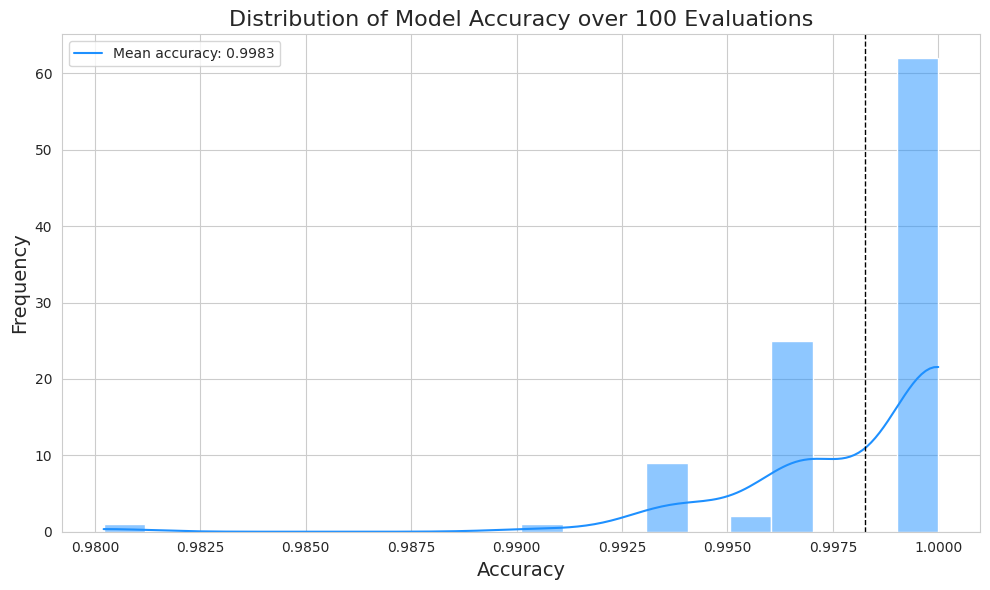

Mean Accuracy: 0.9983
Standard Deviation: 0.0029


In [118]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 생성
acc_list = [evaluate_maml_model(model, tasks_data, best_params) for _ in range(100)]

# 그래프 스타일 설정
sns.set_style("whitegrid")  # 배경에 그리드 추가
plt.figure(figsize=(10, 6))  # 그래프 크기 설정

# 히스토그램 그리기
sns.histplot(acc_list, kde=True, color="dodgerblue", bins=20)
plt.axvline(np.mean(acc_list), color='k', linestyle='dashed', linewidth=1)  # 평균값 선 추가

# 제목 및 레이블 추가
plt.title("Distribution of Model Accuracy over 100 Evaluations", fontsize=16)
plt.xlabel("Accuracy", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend({f'Mean accuracy: {np.mean(acc_list):.4f}':np.mean(acc_list)})  # 범례 추가

# 결과 표시
plt.tight_layout()
plt.show()

print(f"Mean Accuracy: {np.mean(acc_list):.4f}")
print(f"Standard Deviation: {np.std(acc_list):.4f}")

## Parameter Optimization (If necessary)

해당은 필요 시 사용 가능하다. 현재는 사용하지 않음.

In [ ]:
import optuna

# 목적 함수 정의
def objective(trial):
    # 하이퍼파라미터 후보 값 설정
    task_lr = trial.suggest_float("task_lr", 1e-6, 1e-4, log=True)
    meta_lr = trial.suggest_float("meta_lr", 1e-5, 1e-3, log=True)
    num_adaptation_steps = trial.suggest_int("num_adaptation_steps", 1, 5)

    # 모델 생성 및 학습
    model = SimpleModel(processed_data.shape[1] - 2, best_params)
    maml(model, tasks_data, num_adaptation_steps=num_adaptation_steps, task_lr=task_lr, meta_lr=meta_lr, num_epochs=500, checkpoint_dir='checkpoints', log_interval=100)

    # 검증 데이터에서 성능 평가
    accuracy = evaluate_maml_model(model, tasks_data, best_params)

    # 정확도 반환
    return accuracy

# Optuna를 사용하여 최적의 하이퍼파라미터 찾기
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 결과 출력
print(f"Best hyperparameters: {study.best_params}")

[I 2023-09-29 07:46:56,834] A new study created in memory with name: no-name-505f7b58-19b8-4999-8396-8d9b314ba21a


Epoch 0/500, Average Loss: 0.6951
Epoch 100/500, Average Loss: 0.6433
Epoch 200/500, Average Loss: 0.6036
Epoch 300/500, Average Loss: 0.5658
Epoch 400/500, Average Loss: 0.5447


[I 2023-09-29 07:47:28,848] Trial 0 finished with value: 0.7 and parameters: {'task_lr': 1.886670751476358e-05, 'meta_lr': 5.3522712621413106e-05, 'num_adaptation_steps': 3}. Best is trial 0 with value: 0.7.


Epoch 0/500, Average Loss: 0.6946
Epoch 100/500, Average Loss: 0.5083
Epoch 200/500, Average Loss: 0.4789
Epoch 300/500, Average Loss: 0.4606
Epoch 400/500, Average Loss: 0.3792


[I 2023-09-29 07:48:07,179] Trial 1 finished with value: 0.821875 and parameters: {'task_lr': 1.7666531408935878e-05, 'meta_lr': 0.0005926237127519462, 'num_adaptation_steps': 4}. Best is trial 1 with value: 0.821875.


Epoch 0/500, Average Loss: 0.6966
Epoch 100/500, Average Loss: 0.6714
Epoch 200/500, Average Loss: 0.6465
Epoch 300/500, Average Loss: 0.6270
Epoch 400/500, Average Loss: 0.5994


[I 2023-09-29 07:48:44,065] Trial 2 finished with value: 0.6875 and parameters: {'task_lr': 2.5687105157541556e-05, 'meta_lr': 2.5084689267069492e-05, 'num_adaptation_steps': 4}. Best is trial 1 with value: 0.821875.


Epoch 0/500, Average Loss: 0.7037
Epoch 100/500, Average Loss: 0.6174
Epoch 200/500, Average Loss: 0.5710
Epoch 300/500, Average Loss: 0.5411
Epoch 400/500, Average Loss: 0.5211


[I 2023-09-29 07:49:08,905] Trial 3 finished with value: 0.70625 and parameters: {'task_lr': 1.6533715769133126e-06, 'meta_lr': 9.55639791586404e-05, 'num_adaptation_steps': 2}. Best is trial 1 with value: 0.821875.


Epoch 0/500, Average Loss: 0.6908
Epoch 100/500, Average Loss: 0.4848
Epoch 200/500, Average Loss: 0.4159
Epoch 300/500, Average Loss: 0.3939
Epoch 400/500, Average Loss: 0.3333


[I 2023-09-29 07:49:50,865] Trial 4 finished with value: 0.8375 and parameters: {'task_lr': 2.4908629815578665e-06, 'meta_lr': 0.000982535887955168, 'num_adaptation_steps': 5}. Best is trial 4 with value: 0.8375.


Epoch 0/500, Average Loss: 0.7048
Epoch 100/500, Average Loss: 0.6638
Epoch 200/500, Average Loss: 0.6445
Epoch 300/500, Average Loss: 0.6330
Epoch 400/500, Average Loss: 0.5989


[I 2023-09-29 07:50:32,631] Trial 5 finished with value: 0.68125 and parameters: {'task_lr': 8.314495656605927e-05, 'meta_lr': 2.8944620485751005e-05, 'num_adaptation_steps': 5}. Best is trial 4 with value: 0.8375.


Epoch 0/500, Average Loss: 0.6858
Epoch 100/500, Average Loss: 0.5888
Epoch 200/500, Average Loss: 0.5443
Epoch 300/500, Average Loss: 0.5293
Epoch 400/500, Average Loss: 0.5310


[I 2023-09-29 07:51:09,963] Trial 6 finished with value: 0.7375 and parameters: {'task_lr': 1.9465335808911793e-05, 'meta_lr': 0.00011946763774909319, 'num_adaptation_steps': 4}. Best is trial 4 with value: 0.8375.


Epoch 0/500, Average Loss: 0.6974
Epoch 100/500, Average Loss: 0.5047
Epoch 200/500, Average Loss: 0.4837
Epoch 300/500, Average Loss: 0.4771
Epoch 400/500, Average Loss: 0.4367


[I 2023-09-29 07:51:29,219] Trial 7 finished with value: 0.75 and parameters: {'task_lr': 7.06770951986716e-06, 'meta_lr': 0.00036217678629362545, 'num_adaptation_steps': 1}. Best is trial 4 with value: 0.8375.


Epoch 0/500, Average Loss: 0.7012
Epoch 100/500, Average Loss: 0.6006
Epoch 200/500, Average Loss: 0.5298
Epoch 300/500, Average Loss: 0.5145
Epoch 400/500, Average Loss: 0.5167


[I 2023-09-29 07:51:47,821] Trial 8 finished with value: 0.73125 and parameters: {'task_lr': 1.4863316702050252e-05, 'meta_lr': 0.0001291031317169083, 'num_adaptation_steps': 1}. Best is trial 4 with value: 0.8375.


Epoch 0/500, Average Loss: 0.6804
Epoch 100/500, Average Loss: 0.4437
Epoch 200/500, Average Loss: 0.4339
Epoch 300/500, Average Loss: 0.3637
Epoch 400/500, Average Loss: 0.3585


[I 2023-09-29 07:52:06,871] Trial 9 finished with value: 0.903125 and parameters: {'task_lr': 1.5811305439438314e-06, 'meta_lr': 0.0009934465490366903, 'num_adaptation_steps': 1}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6990
Epoch 100/500, Average Loss: 0.5024
Epoch 200/500, Average Loss: 0.4788
Epoch 300/500, Average Loss: 0.4451
Epoch 400/500, Average Loss: 0.4404


[I 2023-09-29 07:52:31,337] Trial 10 finished with value: 0.790625 and parameters: {'task_lr': 1.045103755917374e-06, 'meta_lr': 0.0004632087661483208, 'num_adaptation_steps': 2}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6866
Epoch 100/500, Average Loss: 0.4916
Epoch 200/500, Average Loss: 0.4493
Epoch 300/500, Average Loss: 0.3919
Epoch 400/500, Average Loss: 0.3575


[I 2023-09-29 07:53:13,254] Trial 11 finished with value: 0.85625 and parameters: {'task_lr': 2.2777946189510776e-06, 'meta_lr': 0.0009748542635230035, 'num_adaptation_steps': 5}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6984
Epoch 100/500, Average Loss: 0.4911
Epoch 200/500, Average Loss: 0.4360
Epoch 300/500, Average Loss: 0.3841
Epoch 400/500, Average Loss: 0.2940


[I 2023-09-29 07:53:37,733] Trial 12 finished with value: 0.84375 and parameters: {'task_lr': 3.2208395050957132e-06, 'meta_lr': 0.0009899709647368464, 'num_adaptation_steps': 2}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6993
Epoch 100/500, Average Loss: 0.5171
Epoch 200/500, Average Loss: 0.4865
Epoch 300/500, Average Loss: 0.4554
Epoch 400/500, Average Loss: 0.4649


[I 2023-09-29 07:54:07,986] Trial 13 finished with value: 0.775 and parameters: {'task_lr': 4.155654212374064e-06, 'meta_lr': 0.00033553929568623384, 'num_adaptation_steps': 3}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6793
Epoch 100/500, Average Loss: 0.5378
Epoch 200/500, Average Loss: 0.5040
Epoch 300/500, Average Loss: 0.4938
Epoch 400/500, Average Loss: 0.4556


[I 2023-09-29 07:54:50,243] Trial 14 finished with value: 0.759375 and parameters: {'task_lr': 1.029458735917024e-06, 'meta_lr': 0.00023252544718875724, 'num_adaptation_steps': 5}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6935
Epoch 100/500, Average Loss: 0.4891
Epoch 200/500, Average Loss: 0.4515
Epoch 300/500, Average Loss: 0.4367
Epoch 400/500, Average Loss: 0.3706


[I 2023-09-29 07:55:08,976] Trial 15 finished with value: 0.859375 and parameters: {'task_lr': 1.985273070318662e-06, 'meta_lr': 0.0007128371604959475, 'num_adaptation_steps': 1}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.7010
Epoch 100/500, Average Loss: 0.6875
Epoch 200/500, Average Loss: 0.6846
Epoch 300/500, Average Loss: 0.6661
Epoch 400/500, Average Loss: 0.6632


[I 2023-09-29 07:55:28,400] Trial 16 finished with value: 0.6375 and parameters: {'task_lr': 5.412777664996498e-06, 'meta_lr': 1.0747636880506082e-05, 'num_adaptation_steps': 1}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.7043
Epoch 100/500, Average Loss: 0.5330
Epoch 200/500, Average Loss: 0.5125
Epoch 300/500, Average Loss: 0.4903
Epoch 400/500, Average Loss: 0.4480


[I 2023-09-29 07:55:46,993] Trial 17 finished with value: 0.740625 and parameters: {'task_lr': 1.9851815110883727e-06, 'meta_lr': 0.00023061194851791206, 'num_adaptation_steps': 1}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6949
Epoch 100/500, Average Loss: 0.5123
Epoch 200/500, Average Loss: 0.4971
Epoch 300/500, Average Loss: 0.4271
Epoch 400/500, Average Loss: 0.3861


[I 2023-09-29 07:56:11,607] Trial 18 finished with value: 0.809375 and parameters: {'task_lr': 3.6769466212057053e-06, 'meta_lr': 0.0005394025716243146, 'num_adaptation_steps': 2}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6815
Epoch 100/500, Average Loss: 0.4924
Epoch 200/500, Average Loss: 0.4710
Epoch 300/500, Average Loss: 0.4020
Epoch 400/500, Average Loss: 0.3669


[I 2023-09-29 07:56:30,463] Trial 19 finished with value: 0.8375 and parameters: {'task_lr': 1.7745598522969593e-06, 'meta_lr': 0.0006372717783856516, 'num_adaptation_steps': 1}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6774
Epoch 100/500, Average Loss: 0.5241
Epoch 200/500, Average Loss: 0.5289
Epoch 300/500, Average Loss: 0.5023
Epoch 400/500, Average Loss: 0.4832


[I 2023-09-29 07:56:55,174] Trial 20 finished with value: 0.709375 and parameters: {'task_lr': 8.411434471155316e-06, 'meta_lr': 0.0002457964778965786, 'num_adaptation_steps': 2}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6966
Epoch 100/500, Average Loss: 0.4817
Epoch 200/500, Average Loss: 0.4315
Epoch 300/500, Average Loss: 0.3881
Epoch 400/500, Average Loss: 0.3459


[I 2023-09-29 07:57:25,624] Trial 21 finished with value: 0.871875 and parameters: {'task_lr': 2.6385124614439363e-06, 'meta_lr': 0.0008785789626815577, 'num_adaptation_steps': 3}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.7033
Epoch 100/500, Average Loss: 0.4951
Epoch 200/500, Average Loss: 0.4622
Epoch 300/500, Average Loss: 0.4252
Epoch 400/500, Average Loss: 0.3805


[I 2023-09-29 07:57:55,808] Trial 22 finished with value: 0.840625 and parameters: {'task_lr': 1.4153566928721363e-06, 'meta_lr': 0.0007279031638948376, 'num_adaptation_steps': 3}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6814
Epoch 100/500, Average Loss: 0.5174
Epoch 200/500, Average Loss: 0.4763
Epoch 300/500, Average Loss: 0.4948
Epoch 400/500, Average Loss: 0.4545


[I 2023-09-29 07:58:26,539] Trial 23 finished with value: 0.790625 and parameters: {'task_lr': 2.807196505473132e-06, 'meta_lr': 0.00044406203688801755, 'num_adaptation_steps': 3}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.7029
Epoch 100/500, Average Loss: 0.5068
Epoch 200/500, Average Loss: 0.4447
Epoch 300/500, Average Loss: 0.4263
Epoch 400/500, Average Loss: 0.3986


[I 2023-09-29 07:58:45,150] Trial 24 finished with value: 0.825 and parameters: {'task_lr': 1.4989563775743659e-06, 'meta_lr': 0.0006438167457417057, 'num_adaptation_steps': 1}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6842
Epoch 100/500, Average Loss: 0.5032
Epoch 200/500, Average Loss: 0.4673
Epoch 300/500, Average Loss: 0.4035
Epoch 400/500, Average Loss: 0.3636


[I 2023-09-29 07:59:10,137] Trial 25 finished with value: 0.825 and parameters: {'task_lr': 4.62800162919696e-06, 'meta_lr': 0.0007510571476987291, 'num_adaptation_steps': 2}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6958
Epoch 100/500, Average Loss: 0.5151
Epoch 200/500, Average Loss: 0.4784
Epoch 300/500, Average Loss: 0.4686
Epoch 400/500, Average Loss: 0.4634


[I 2023-09-29 07:59:46,200] Trial 26 finished with value: 0.765625 and parameters: {'task_lr': 2.6055608370174097e-06, 'meta_lr': 0.0003777301892246076, 'num_adaptation_steps': 4}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6902
Epoch 100/500, Average Loss: 0.5023
Epoch 200/500, Average Loss: 0.4587
Epoch 300/500, Average Loss: 0.4064
Epoch 400/500, Average Loss: 0.3797


[I 2023-09-29 08:00:05,047] Trial 27 finished with value: 0.809375 and parameters: {'task_lr': 1.3167099528106323e-06, 'meta_lr': 0.0007814002933421105, 'num_adaptation_steps': 1}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6833
Epoch 100/500, Average Loss: 0.5204
Epoch 200/500, Average Loss: 0.5060
Epoch 300/500, Average Loss: 0.4706
Epoch 400/500, Average Loss: 0.4363


[I 2023-09-29 08:00:29,530] Trial 28 finished with value: 0.80625 and parameters: {'task_lr': 3.377083966480866e-06, 'meta_lr': 0.0004804177645011337, 'num_adaptation_steps': 2}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.7017
Epoch 100/500, Average Loss: 0.4940
Epoch 200/500, Average Loss: 0.4338
Epoch 300/500, Average Loss: 0.3768
Epoch 400/500, Average Loss: 0.3090


[I 2023-09-29 08:00:59,637] Trial 29 finished with value: 0.84375 and parameters: {'task_lr': 2.1158908114484414e-06, 'meta_lr': 0.0009854528261699258, 'num_adaptation_steps': 3}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6909
Epoch 100/500, Average Loss: 0.5125
Epoch 200/500, Average Loss: 0.4986
Epoch 300/500, Average Loss: 0.4817
Epoch 400/500, Average Loss: 0.4538


[I 2023-09-29 08:01:30,208] Trial 30 finished with value: 0.784375 and parameters: {'task_lr': 6.066575389421262e-06, 'meta_lr': 0.0002895394765609516, 'num_adaptation_steps': 3}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.7057
Epoch 100/500, Average Loss: 0.4715
Epoch 200/500, Average Loss: 0.4010
Epoch 300/500, Average Loss: 0.3642
Epoch 400/500, Average Loss: 0.3263


[I 2023-09-29 08:02:06,327] Trial 31 finished with value: 0.89375 and parameters: {'task_lr': 2.246110849375405e-06, 'meta_lr': 0.0009777071790081175, 'num_adaptation_steps': 4}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6935
Epoch 100/500, Average Loss: 0.4939
Epoch 200/500, Average Loss: 0.3923
Epoch 300/500, Average Loss: 0.4221
Epoch 400/500, Average Loss: 0.3479


[I 2023-09-29 08:02:43,213] Trial 32 finished with value: 0.828125 and parameters: {'task_lr': 2.0358510101684768e-06, 'meta_lr': 0.000698375544312371, 'num_adaptation_steps': 4}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.7177
Epoch 100/500, Average Loss: 0.5154
Epoch 200/500, Average Loss: 0.5075
Epoch 300/500, Average Loss: 0.4519
Epoch 400/500, Average Loss: 0.4115


[I 2023-09-29 08:03:19,592] Trial 33 finished with value: 0.846875 and parameters: {'task_lr': 3.0198093107618633e-06, 'meta_lr': 0.0005775874582295357, 'num_adaptation_steps': 4}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6929
Epoch 100/500, Average Loss: 0.5064
Epoch 200/500, Average Loss: 0.4769
Epoch 300/500, Average Loss: 0.4346
Epoch 400/500, Average Loss: 0.4441


[I 2023-09-29 08:03:55,442] Trial 34 finished with value: 0.76875 and parameters: {'task_lr': 1.2443149786913803e-06, 'meta_lr': 0.0005167002420924806, 'num_adaptation_steps': 4}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.7016
Epoch 100/500, Average Loss: 0.4779
Epoch 200/500, Average Loss: 0.4527
Epoch 300/500, Average Loss: 0.3837
Epoch 400/500, Average Loss: 0.3309


[I 2023-09-29 08:04:14,050] Trial 35 finished with value: 0.8375 and parameters: {'task_lr': 1.8487136473452223e-06, 'meta_lr': 0.0008282189403425097, 'num_adaptation_steps': 1}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6768
Epoch 100/500, Average Loss: 0.5075
Epoch 200/500, Average Loss: 0.4701
Epoch 300/500, Average Loss: 0.4283
Epoch 400/500, Average Loss: 0.3792


[I 2023-09-29 08:04:49,427] Trial 36 finished with value: 0.8125 and parameters: {'task_lr': 4.498903175890339e-06, 'meta_lr': 0.0005783272986702849, 'num_adaptation_steps': 4}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.7199
Epoch 100/500, Average Loss: 0.5005
Epoch 200/500, Average Loss: 0.4548
Epoch 300/500, Average Loss: 0.3834
Epoch 400/500, Average Loss: 0.3753


[I 2023-09-29 08:05:13,712] Trial 37 finished with value: 0.853125 and parameters: {'task_lr': 1.6342234600467273e-06, 'meta_lr': 0.0007614837495135495, 'num_adaptation_steps': 2}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6888
Epoch 100/500, Average Loss: 0.4962
Epoch 200/500, Average Loss: 0.4552
Epoch 300/500, Average Loss: 0.4174
Epoch 400/500, Average Loss: 0.3439


[I 2023-09-29 08:05:55,901] Trial 38 finished with value: 0.853125 and parameters: {'task_lr': 2.5417606403808615e-06, 'meta_lr': 0.0009933809096555083, 'num_adaptation_steps': 5}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6957
Epoch 100/500, Average Loss: 0.5270
Epoch 200/500, Average Loss: 0.4686
Epoch 300/500, Average Loss: 0.4457
Epoch 400/500, Average Loss: 0.4310


[I 2023-09-29 08:06:26,100] Trial 39 finished with value: 0.79375 and parameters: {'task_lr': 3.488781941792605e-06, 'meta_lr': 0.00040952062651291557, 'num_adaptation_steps': 3}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6756
Epoch 100/500, Average Loss: 0.4868
Epoch 200/500, Average Loss: 0.4973
Epoch 300/500, Average Loss: 0.4376
Epoch 400/500, Average Loss: 0.4273


[I 2023-09-29 08:06:44,535] Trial 40 finished with value: 0.834375 and parameters: {'task_lr': 1.365323471298279e-06, 'meta_lr': 0.0006000976398388106, 'num_adaptation_steps': 1}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6880
Epoch 100/500, Average Loss: 0.4935
Epoch 200/500, Average Loss: 0.4360
Epoch 300/500, Average Loss: 0.3923
Epoch 400/500, Average Loss: 0.3318


[I 2023-09-29 08:07:26,314] Trial 41 finished with value: 0.8625 and parameters: {'task_lr': 2.325188600641957e-06, 'meta_lr': 0.0008734686277501384, 'num_adaptation_steps': 5}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6980
Epoch 100/500, Average Loss: 0.4815
Epoch 200/500, Average Loss: 0.4654
Epoch 300/500, Average Loss: 0.4178
Epoch 400/500, Average Loss: 0.3825


[I 2023-09-29 08:08:08,370] Trial 42 finished with value: 0.853125 and parameters: {'task_lr': 2.2981793515035713e-06, 'meta_lr': 0.0008027581267136221, 'num_adaptation_steps': 5}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6857
Epoch 100/500, Average Loss: 0.4933
Epoch 200/500, Average Loss: 0.4473
Epoch 300/500, Average Loss: 0.3951
Epoch 400/500, Average Loss: 0.3378


[I 2023-09-29 08:08:50,358] Trial 43 finished with value: 0.81875 and parameters: {'task_lr': 1.711829063016212e-06, 'meta_lr': 0.0008375032679109234, 'num_adaptation_steps': 5}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6963
Epoch 100/500, Average Loss: 0.5107
Epoch 200/500, Average Loss: 0.4786
Epoch 300/500, Average Loss: 0.4685
Epoch 400/500, Average Loss: 0.4397


[I 2023-09-29 08:09:27,245] Trial 44 finished with value: 0.75625 and parameters: {'task_lr': 2.8205417223569124e-06, 'meta_lr': 0.000501398054677468, 'num_adaptation_steps': 4}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6914
Epoch 100/500, Average Loss: 0.5361
Epoch 200/500, Average Loss: 0.4576
Epoch 300/500, Average Loss: 0.4292
Epoch 400/500, Average Loss: 0.4251


[I 2023-09-29 08:10:08,336] Trial 45 finished with value: 0.840625 and parameters: {'task_lr': 1.1477679586491098e-06, 'meta_lr': 0.0006495595711571849, 'num_adaptation_steps': 5}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6948
Epoch 100/500, Average Loss: 0.5014
Epoch 200/500, Average Loss: 0.4467
Epoch 300/500, Average Loss: 0.4471
Epoch 400/500, Average Loss: 0.3924


[I 2023-09-29 08:10:44,338] Trial 46 finished with value: 0.8375 and parameters: {'task_lr': 1.0151321294194058e-06, 'meta_lr': 0.0008909306108703496, 'num_adaptation_steps': 4}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6944
Epoch 100/500, Average Loss: 0.4983
Epoch 200/500, Average Loss: 0.4233
Epoch 300/500, Average Loss: 0.3816
Epoch 400/500, Average Loss: 0.3418


[I 2023-09-29 08:11:25,722] Trial 47 finished with value: 0.865625 and parameters: {'task_lr': 1.5389714221373827e-06, 'meta_lr': 0.0009955321494359128, 'num_adaptation_steps': 5}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6932
Epoch 100/500, Average Loss: 0.4845
Epoch 200/500, Average Loss: 0.4154
Epoch 300/500, Average Loss: 0.3436
Epoch 400/500, Average Loss: 0.3253


[I 2023-09-29 08:12:07,843] Trial 48 finished with value: 0.871875 and parameters: {'task_lr': 1.5719379218744298e-06, 'meta_lr': 0.0009881188967351554, 'num_adaptation_steps': 5}. Best is trial 9 with value: 0.903125.


Epoch 0/500, Average Loss: 0.6928
Epoch 100/500, Average Loss: 0.5207
Epoch 200/500, Average Loss: 0.4804
Epoch 300/500, Average Loss: 0.4749
Epoch 400/500, Average Loss: 0.4495


[I 2023-09-29 08:12:49,442] Trial 49 finished with value: 0.775 and parameters: {'task_lr': 1.529131894506707e-06, 'meta_lr': 0.0004108634429075988, 'num_adaptation_steps': 5}. Best is trial 9 with value: 0.903125.


Best hyperparameters: {'task_lr': 1.5811305439438314e-06, 'meta_lr': 0.0009934465490366903, 'num_adaptation_steps': 1}


In [ ]:
# Best Parameter로 MAML 학습 실행
model = SimpleModel(processed_data.shape[1] - 2, best_params)
maml(model, tasks_data, num_adaptation_steps=1, task_lr = 1.5811305439438314e-06, meta_lr = 0.0009934465490366903, num_epochs=500, checkpoint_dir='checkpoints', log_interval=10)

Epoch 0/500, Average Loss: 0.6857
Epoch 10/500, Average Loss: 0.6192
Epoch 20/500, Average Loss: 0.5739
Epoch 30/500, Average Loss: 0.5651
Epoch 40/500, Average Loss: 0.5308
Epoch 50/500, Average Loss: 0.5222
Epoch 60/500, Average Loss: 0.5161
Epoch 70/500, Average Loss: 0.5195
Epoch 80/500, Average Loss: 0.5140
Epoch 90/500, Average Loss: 0.5036
Epoch 100/500, Average Loss: 0.4971
Epoch 110/500, Average Loss: 0.5352
Epoch 120/500, Average Loss: 0.4692
Epoch 130/500, Average Loss: 0.4725
Epoch 140/500, Average Loss: 0.4748
Epoch 150/500, Average Loss: 0.4710
Epoch 160/500, Average Loss: 0.4735
Epoch 170/500, Average Loss: 0.4482
Epoch 180/500, Average Loss: 0.4555
Epoch 190/500, Average Loss: 0.4405
Epoch 200/500, Average Loss: 0.4549
Epoch 210/500, Average Loss: 0.4339
Epoch 220/500, Average Loss: 0.4184
Epoch 230/500, Average Loss: 0.3952
Epoch 240/500, Average Loss: 0.4004
Epoch 250/500, Average Loss: 0.3787
Epoch 260/500, Average Loss: 0.3979
Epoch 270/500, Average Loss: 0.3724
Epo

## Model Gender-Fairness

In [86]:
def evaluate_maml_model_by_gender(model, tasks_data, params, gender, num_adaptation_steps=1, task_lr=1e-2):
    accuracies = []

    for task_data in tasks_data:
        # Filter data by gender
        gender_idx = (task_data['val'][0][:, -8] == gender).nonzero().squeeze()  # -8 to get the 'gender_M' column
        gender_features = task_data['val'][0][gender_idx]

        # Check for 0-d tensor
        if gender_idx.dim() == 0:
            continue  # Skip if no data for the specified gender in this task

        gender_labels = task_data['val'][1][gender_idx]

        if len(gender_labels) == 0:
            continue  # Skip if no data for the specified gender in this task

        # Adaptation step
        task_model = SimpleModel(processed_data.shape[1] - 2, params)  # Only exclude 'is_dead' and 'cluster'
        task_model.load_state_dict(model.state_dict())
        task_optimizer = optim.SGD(task_model.parameters(), lr=task_lr)


        for step in range(num_adaptation_steps):
            train_output = task_model(task_data['train'][0])
            train_loss = loss_function(train_output, task_data['train'][1])
            task_optimizer.zero_grad()
            train_loss.backward()
            task_optimizer.step()

        # Evaluate on validation data for the specific gender
        val_output = task_model(gender_features)
        val_predictions = torch.sigmoid(val_output) > 0.5
        corrects = (val_predictions == gender_labels.bool()).sum().item()
        accuracy = corrects / len(gender_labels)
        accuracies.append(accuracy)

    return np.mean(accuracies) if accuracies else 0  # Return 0 if no data for the gender across all tasks

# 남자 데이터로 평가
male_accuracy = evaluate_maml_model_by_gender(model, tasks_data, best_params, gender=1.0)
print(f"Mean Accuracy for Male: {male_accuracy:.4f}")

# 여자 데이터로 평가
female_accuracy = evaluate_maml_model_by_gender(model, tasks_data, best_params, gender=0.0)
print(f"Mean Accuracy for Female: {female_accuracy:.4f}")

Mean Accuracy for Male: 0.9818
Mean Accuracy for Female: 1.0000


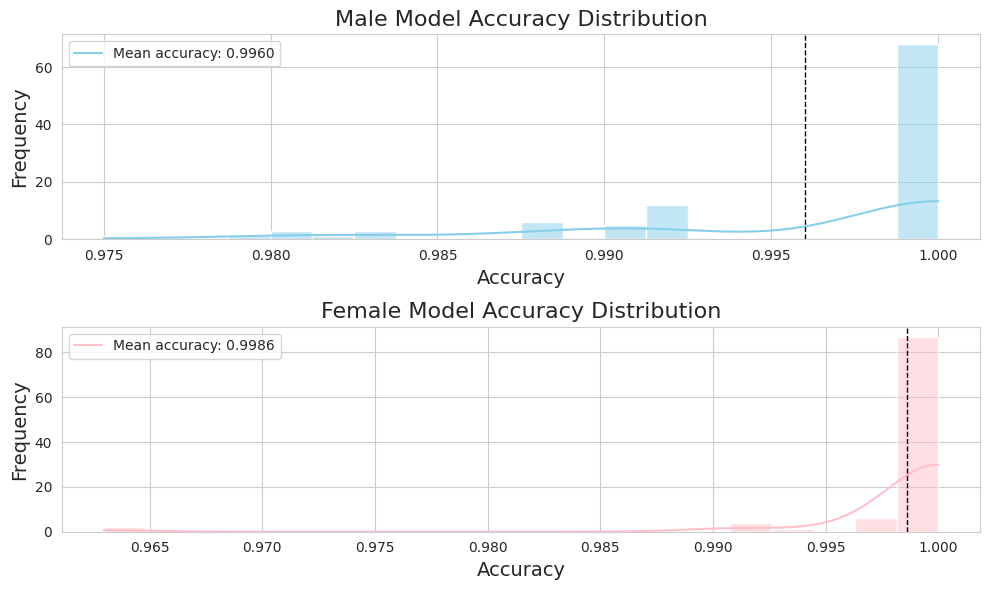

Male Mean Accuracy: 0.9960
Male Standard Deviation: 0.0064
Female Mean Accuracy: 0.9986
Female Standard Deviation: 0.0055


In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 생성
male_acc_list = [evaluate_maml_model_by_gender(model, tasks_data, best_params, gender=1.0) for _ in range(100)]
female_acc_list = [evaluate_maml_model_by_gender(model, tasks_data, best_params, gender=0.0) for _ in range(100)]

# 그래프 스타일 설정
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# 남성 정확도 그래프
plt.subplot(2, 1, 1)
sns.histplot(male_acc_list, kde=True, color="skyblue", bins=20)
plt.axvline(np.mean(male_acc_list), color='k', linestyle='dashed', linewidth=1)
plt.title("Male Model Accuracy Distribution", fontsize=16)
plt.xlabel("Accuracy", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend({f'Mean accuracy: {np.mean(male_acc_list):.4f}':np.mean(male_acc_list)})

# 여성 정확도 그래프
plt.subplot(2, 1, 2)
sns.histplot(female_acc_list, kde=True, color="pink", bins=20)
plt.axvline(np.mean(female_acc_list), color='k', linestyle='dashed', linewidth=1)
plt.title("Female Model Accuracy Distribution", fontsize=16)
plt.xlabel("Accuracy", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend({f'Mean accuracy: {np.mean(female_acc_list):.4f}':np.mean(female_acc_list)})

# 그래프 출력
plt.tight_layout()
plt.show()

# 결과 표시
print(f"Male Mean Accuracy: {np.mean(male_acc_list):.4f}")
print(f"Male Standard Deviation: {np.std(male_acc_list):.4f}")
print(f"Female Mean Accuracy: {np.mean(female_acc_list):.4f}")
print(f"Female Standard Deviation: {np.std(female_acc_list):.4f}")
